For installing torchsummary use `pip install torchsummary`

In [1]:
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt

/home/shubuni/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Multinomial Classification of MNIST 

1. Load the MNIST dataset by clicking through the first cells and see how to depict some samples. Please note that a training and a test dataset are loaded. Make sure that only the training set will be used for training and the test dataset just for evaluation (accuracy). 
2. Implement the multinomial logistic regression model by completing the code in the functions \verb|linear_trsf|, \verb|softmax|, \verb|predict|, \verb|loss_ce|, \verb|cost_ce|. 
3. Implement the mini-batch gradient descent training loop configured by number of epochs, batch size and learning rate. Implement the gradient explicitly (without autograd). Train the model with \verb|nepochs=10|, \verb|nbatch=64| and \verb|lr=0.01|. 
4. Tune learning rate and batch size and qualitatively characterise the behaviour. What is your favorite combination (learning rate, batch size, number of epochs)
5. Build and train the model with full-fledge pytorch incl. autograd. Implement a model class inheriting from $torch.nn.Module$ and use the layer functionality in the package $torch.nn$ (see lecture). Prove that you obtain the same accuracy.


#### Hints 
* Keep an eye on the shapes of the tensors (as passed into the functions and as used within the functions (and declared in the function descriptions).
* For each implemented function, run a small test with dummy input tensors (of the required shape) and check whether it outputs a tensor with expected shape and no 'nan'.
* Possibly, add \verb|assert()| statements in the code.
* For the training loop perform a training with only a single batch of size 64. Here, you should be able to obtain 100% training accuracy.

### 1. Loading the Data

Click through the cells below to load the MNIST dataset and learn how to access its samples.

#### Dataset

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 18012748.54it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 90874488.99it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 11088525.85it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6258386.59it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw


In [3]:
print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [4]:
print(len(training_data))
x, y = training_data[5]
print(type(x), x.shape, x.dtype)
print(type(y), y)

60000
<class 'torch.Tensor'> torch.Size([1, 28, 28]) torch.float32
<class 'int'> 2


#### Depict samples

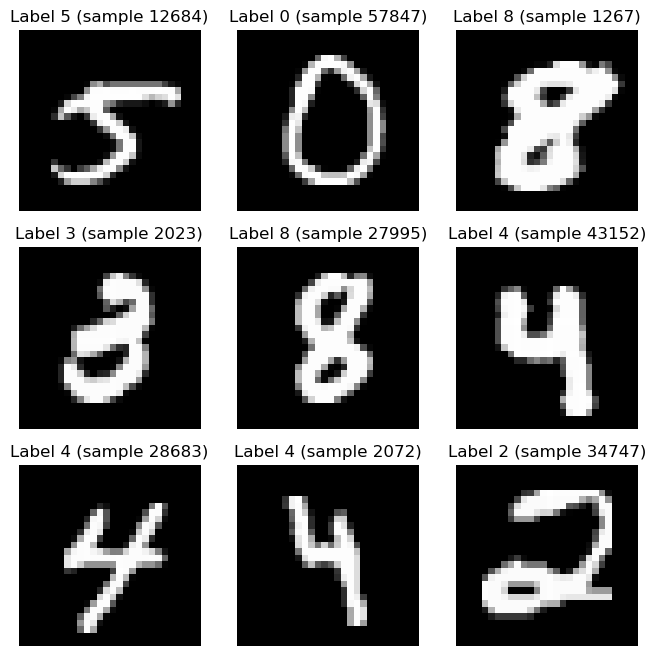

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Label %i (sample %i)"%(label,sample_idx))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Data Loader (see lecture)

In [7]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [8]:
data_train, labels_train = next(iter(train_dataloader))
print(f"Feature batch shape: {data_train.shape}")
print(f"Labels batch shape: {labels_train.shape}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


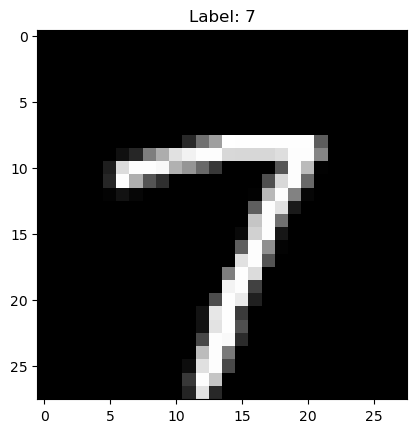

In [9]:
img = data_train[0].squeeze()
label = labels_train[0]
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

### 2. Multinomial Logistic Regression

Now, implement the model, i.e. multinomial logistic regression and the loss/cost function (cross-entropy cost).

To that end, implement the python functions below. 
All arguments are pytorch tensors with indicated shapes.

In [10]:
def linear_trsf(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    nb = x.shape[0]
    x_reshaped = x.reshape(nb, -1)  # flattens the input
    return torch.mm(x_reshaped, W.t()) + b  # (nb,10)
    
    # YOUR CODE (END)

def softmax(z):
    """
    z -- tensor of shape (nb,10)
    """
    # YOUR CODE (START)
    exp_z = torch.exp(z - z.max(dim=1, keepdim=True).values)
    sum_exp_z = exp_z.sum(dim=1, keepdim=True)
    return exp_z / sum_exp_z  # (nb,10)
    
    # YOUR CODE (END)
    
def predict(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    z = linear_trsf(x, W, b)
    return softmax(z)
    # YOUR CODE (END)


##### TEST

In [11]:
nb = 64  # batch size
x_dummy = torch.randn(nb, 1, 28, 28)  # (nb,1,28,28)

W_dummy = torch.randn(10, 28*28)  # (10,28*28)
b_dummy = torch.randn(1, 10)  # (1,10)

z_dummy = linear_trsf(x_dummy, W_dummy, b_dummy)
print(f"Shape of linear_trsf output: {z_dummy.shape}")

probabilities_dummy = softmax(z_dummy)
print(f"Shape of softmax output: {probabilities_dummy.shape}")
print(f"Sum of probabilities for a sample: {probabilities_dummy[0].sum()}")

pred_dummy = predict(x_dummy, W_dummy, b_dummy)
print(f"Shape of predict output: {pred_dummy.shape}")

Shape of linear_trsf output: torch.Size([64, 10])
Shape of softmax output: torch.Size([64, 10])
Sum of probabilities for a sample: 1.0000001192092896
Shape of predict output: torch.Size([64, 10])


In [12]:
W,b = torch.randn((10,28*28)), torch.zeros((1,10))
print(W.shape,b.shape)
u = predict(x,W,b)
print(u.shape, torch.sum(u).item())

torch.Size([10, 784]) torch.Size([1, 10])
torch.Size([1, 10]) 1.0


#### Loss Function

In [44]:
def loss_ce(y, uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    returns -- per sample loss 
    """
    # YOUR CODE (START)
def loss_ce(y, uhat):
    nb = y.shape[0]
    c = uhat.shape[1]
    y = y.long()
    y_one_hot = torch.zeros(nb, c).scatter_(1, y.view(-1, 1), 1)
    loss = -torch.sum(y_one_hot * torch.log(uhat), dim=1)
    return loss

    # YOUR CODE (END)

def cost_ce(y,uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    return -- per batch mean of losses
    """
    # YOUR CODE (START)    
    losses = loss_ce(y, uhat)
    return losses.mean()
    # YOUR CODE (END)


##### TEST

In [45]:
import numpy as np
y = torch.tensor([0,2])
z = torch.tensor([[1.,2,3],[2,2,2]]).reshape(-1,3)
uhat = softmax(z)
print(loss_ce(y,uhat), cost_ce(y,uhat))

tensor([2.4076, 1.0986]) tensor(1.7531)


### 3. Mini-Batch Gradient Descent

For the training, we adopt gradient descent - and start with the implementation of the gradient of the cost function (cross-entropy cost function).  

#### Gradient

In [46]:
def grad_loss_ce(x,u,uhat):
    """
    x -- tensor with shape (nb,1, 28*28)
    u -- tensor with shape (nb,10)
    uhat -- tensor with shape (nb,10)
    returns -- gradW, gradb (same dimension as W and b)
    """
    # YOUR CODE (START)
    nb = x.shape[0]
    x_reshaped = x.reshape(nb, -1)
    u_one_hot = torch.zeros(nb, 10).scatter_(1, u.view(-1, 1), 1)
    gradW = torch.mm(x_reshaped.t(), (uhat - u_one_hot))
    gradb = (uhat - u_one_hot).sum(dim=0, keepdim=True)
    return gradW, gradb
    # YOUR CODE (END)

#### Metrics - Cost, Accuracy

For tracking the progress of the training, we will use two functions: the cost and the accuracy. 

In [47]:
def metrics(X,Y,W,b):
    """
    X -- tensor with shape (nb,1,28*28)
    Y -- tensor with shape (nb,10)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (10,1)
    
    return -- cost, acc (both scalars)
    """
    # YOUR CODE (START)    
    uhat = predict(X, W, b)
    nb = Y.size(0)
    c = uhat.size(1)
    Y = Y.long()
    Y_one_hot = torch.zeros(nb, c).scatter_(1, Y.view(-1, 1), 1)
    cost = cost_ce(Y_one_hot, uhat)
    predictions = torch.argmax(uhat, dim=1)
    correct_predictions = (predictions == Y).float()
    acc = correct_predictions.mean()
    return cost.item(), acc.item()
    # YOUR CODE (END)

#### Training

In [48]:
nepochs = 10
alpha = 0.01
nclasses = 10
nbatch = 64
num_batches = len(training_data)/float(nbatch)

cost_hist = []
acc_hist = []
cost_hist_test = []
acc_hist_test = []

# data loader
train_dataloader = DataLoader(training_data, batch_size=nbatch, shuffle=True)

# test data - we can load all samples for the test since it easily fits into memory
Xtest,Ytest = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True)))

# initial parameters
W,b = torch.randn((10,28*28)), torch.zeros((1,10))

d0 = datetime.now()

for epoch in range(nepochs):
    for X, Y in train_dataloader:
        X = X.view(-1, 28*28)  # flatten X
        uhat = predict(X, W, b)
        gradW, gradb = grad_loss_ce(X, Y, uhat)
        W -= alpha * gradW.t()
        b -= alpha * gradb.squeeze()

    cost_train, acc_train = metrics(X, Y, W, b) 
    cost_hist.append(cost_train)
    acc_hist.append(acc_train)

    Xtest_flat = Xtest.view(-1, 28*28)  # flatten Xtest
    cost_test, acc_test = metrics(Xtest_flat, Ytest, W, b)
    cost_hist_test.append(cost_test)
    acc_hist_test.append(acc_test)

    print(f"Epoch {epoch}: Train cost = {cost_train}, Train acc = {acc_train}, Test cost = {cost_test}, Test acc = {acc_test}")


d = datetime.now()
print(f"Average epoch time: {(d-d0).total_seconds()/nepochs} seconds")

RuntimeError: Expected index [320, 1] to be smaller than self [32, 10] apart from dimension 1

Text(0.5, 1.0, 'Accuracy')

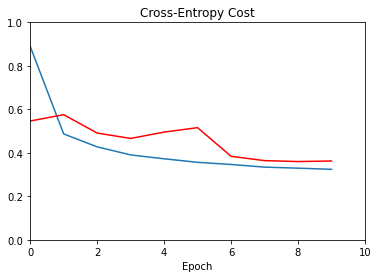

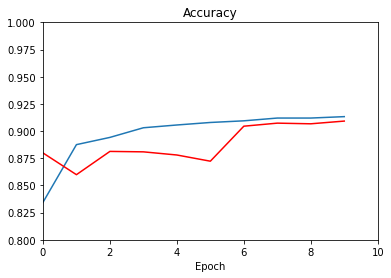

In [18]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")

### 4. Tune learning rate and batch size

Now analyse the training progress with five, well selected settings for each, the learning rate and the batch size.
Make sure that for each setting, a more or less "stable" test performance is achieved, i.e. a status where the test accurace is no longer expected to improve. Choose the number of epochs accordingly.

Finally, prepare suitable plots and tables to make the comparison transparent and characterize in words what you observe. 

Explain the behavior.

### 5. With Full-Fledge PyTorch

In [19]:
class NeuralNetwork(torch.nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = ...
        self.linear  = ...
    
    def forward(self, x): # use just one linear layer and pytorch's CrossEntropyLoss
        z = ...
        return z


In [34]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [35]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [36]:
nbatch = 64
nepochs = 10
learning_rate = 0.01

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
Xtest, Ytest = next(iter(test_loader))
size = len(training_loader.dataset)
nbatches = len(training_loader)

for epoch in range(nepochs):
    cost, acc = 0.0, 0.0
    for batch, (X, Y) in enumerate(training_loader):

    ...    
    ...    
    ...    
        
    cost /= nbatches
    acc /= size
    
    ...
    ...
    ...
    
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)


Epoch 0: 0.983347, 0.798517, 0.603200, 0.867500
Epoch 1: 0.552474, 0.867283, 0.477130, 0.884000
Epoch 2: 0.472336, 0.879833, 0.426591, 0.891300
Epoch 3: 0.433343, 0.886117, 0.398831, 0.896200
Epoch 4: 0.408873, 0.891000, 0.381611, 0.899200
Epoch 5: 0.392192, 0.894483, 0.364884, 0.902000
Epoch 6: 0.379480, 0.897100, 0.355054, 0.905300
Epoch 7: 0.369738, 0.899250, 0.345773, 0.906000
Epoch 8: 0.361385, 0.900750, 0.340056, 0.907500
Epoch 9: 0.354670, 0.902517, 0.333860, 0.907700


Text(0.5, 1.0, 'Accuracy')

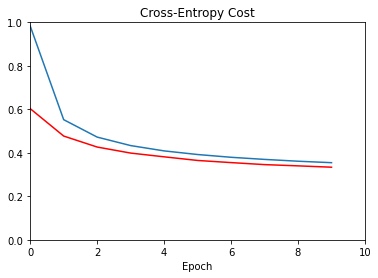

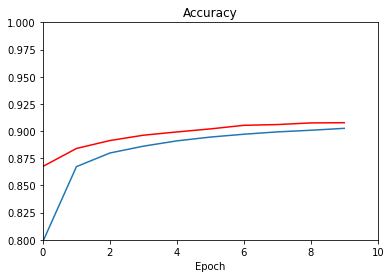

In [37]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")